In [19]:
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
import os
import pandas as pd
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [2]:

labels = ['PNEUMONIA', 'NORMAL']
dataset = []
test_DS = []
val_DS = []

# Populate the dataset list for training
for label in labels:
    path = os.path.join("./Dataset/chest_xray/train", label)
    class_num = labels.index(label)
    for img_name in os.listdir(path):
        dataset.append({"img_name": os.path.join(label, img_name), "label": class_num})

# Populate the dataset list for testing
for label in labels:
    path = os.path.join("./Dataset/chest_xray/test", label)
    class_num = labels.index(label)
    for img_name in os.listdir(path):
        test_DS.append({"img_name": os.path.join(label, img_name), "label": class_num})

# Populate the dataset list for validation
for label in labels:
    path = os.path.join("./Dataset/chest_xray/val", label)
    class_num = labels.index(label)
    for img_name in os.listdir(path):
        val_DS.append({"img_name": os.path.join(label, img_name), "label": class_num})


In [3]:
train_df = pd.DataFrame(dataset)
test_df = pd.DataFrame(test_DS)
val_df = pd.DataFrame(val_DS)


In [4]:
img_size = 150
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor()
])

In [5]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, annotation_file, transform=None):
        self.dataframe = annotation_file
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        img_name = os.path.join(self.root_dir, self.dataframe.iloc[index, 0])
        image = Image.open(img_name).convert("RGB")
        label = int(self.dataframe.iloc[index, 1])

        if self.transform:
            image = self.transform(image)

        return image, label

In [6]:
train_dataset = CustomDataset(root_dir="./Dataset/chest_xray/train", annotation_file=train_df, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = CustomDataset(root_dir="./Dataset/chest_xray/test", annotation_file=test_df, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

val_dataset = CustomDataset(root_dir="./Dataset/chest_xray/val", annotation_file=val_df, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

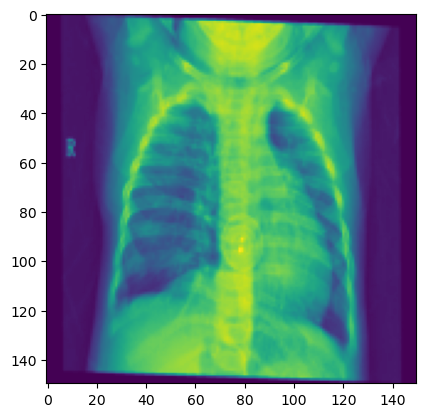

(tensor([[[0.0000, 0.0588, 0.0863,  ..., 0.3569, 0.3333, 0.2196],
         [0.0000, 0.0588, 0.0863,  ..., 0.3451, 0.3255, 0.2157],
         [0.0000, 0.0588, 0.0863,  ..., 0.3294, 0.3098, 0.2039],
         ...,
         [0.0667, 0.0863, 0.1412,  ..., 0.0627, 0.0118, 0.0000],
         [0.0667, 0.0902, 0.1686,  ..., 0.0588, 0.0078, 0.0000],
         [0.0667, 0.0941, 0.1961,  ..., 0.0588, 0.0078, 0.0000]]]), 0)


In [7]:
sample_image, _ = train_dataset[10]
plt.imshow(sample_image.permute(1, 2, 0).numpy())  # Convert tensor to numpy array for visualization
plt.show()
print(train_dataset[100])

In [8]:
class ConvNeuralNetwork(nn.Module):
    def __init__(self, num_classes):
        super(ConvNeuralNetwork, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=5, padding=2)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=7, padding=3)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=11, padding=4)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self._initialize_fc_input_size(img_size)
        self.fc1 = nn.Linear(self.fc_input_size, 128)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(128, num_classes)

    def _initialize_fc_input_size(self, img_size):
        # Dummy forward pass to calculate input size for fully connected layer
        x = torch.randn(1, 1, img_size, img_size)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.maxpool1(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.maxpool2(x)
        self.fc_input_size = x.view(x.size(0), -1).size(1)

    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.maxpool1(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.maxpool2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.relu1(out)
        out = self.fc2(out)
        return out

In [14]:
batch_size = 32
num_classes = 2
learning_rate = 0.001
num_epochs = 5
model = ConvNeuralNetwork(num_classes)
model.load_state_dict(torch.load("lungs.pth"))
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=0.005, momentum=0.9)


In [10]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    n=0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        y_pred = model(inputs)
        loss = criterion(y_pred, labels)
        n=n+1
        print(f"{n}-loss:{loss.item():.4f}")
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    model.eval()
    with torch.no_grad():
        test_acc = 0
        count = 0
        for inputs, labels in test_loader:
            y_pred = model(inputs)
            test_acc += (torch.argmax(y_pred, 1) == labels).float().sum()
            count += len(labels)
        test_acc /= count

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Test Accuracy: {test_acc*100:.2f}%")


1-loss:0.6891
2-loss:0.6829
3-loss:0.6722
4-loss:0.6592
5-loss:0.6487
6-loss:0.6311
7-loss:0.5992
8-loss:0.5325
9-loss:0.5849
10-loss:0.4175
11-loss:0.6716
12-loss:0.7678
13-loss:0.5871
14-loss:0.5344
15-loss:0.7560
16-loss:0.6002
17-loss:0.5795
18-loss:0.5800
19-loss:0.6238
20-loss:0.5212
21-loss:0.6242
22-loss:0.5876
23-loss:0.5335
24-loss:0.6272
25-loss:0.5526
26-loss:0.6578
27-loss:0.6495
28-loss:0.4591
29-loss:0.6557
30-loss:0.6295
31-loss:0.5540
32-loss:0.5229
33-loss:0.5108
34-loss:0.4442
35-loss:0.6419
36-loss:0.4425
37-loss:0.4996
38-loss:0.3631
39-loss:0.5538
40-loss:0.6445
41-loss:0.5667
42-loss:0.8875
43-loss:0.6102
44-loss:0.6530
45-loss:0.5537
46-loss:0.5943
47-loss:0.5566
48-loss:0.6106
49-loss:0.5828
50-loss:0.5579
51-loss:0.6100
52-loss:0.6062
53-loss:0.6120
54-loss:0.5563
55-loss:0.5420
56-loss:0.5107
57-loss:0.4782
58-loss:0.5723
59-loss:0.5032
60-loss:0.3732
61-loss:0.3521
62-loss:0.4028
63-loss:0.5207
64-loss:0.5511
65-loss:0.4056
66-loss:0.7171
67-loss:0.6972
68-l

In [13]:
model.eval()
val_acc = 0
val_count = 0
with torch.no_grad():
    for inputs, labels in val_loader:
        y_pred = model(inputs)
        val_acc += (torch.argmax(y_pred, 1) == labels).float().sum()
        val_count += len(labels)
val_acc /= val_count
print(f"Validation Accuracy: {val_acc*100:.2f}%")

Validation Accuracy: 68.75%


In [12]:
# Save model
torch.save(model.state_dict(), "lungs.pth")